----
----
# <center><b> DLMI Kaggle Challenge </center></b>
# <b> Matteo MARENGO | matteo.marengo@ens-paris-saclay.fr </b>
# <b> Manal MEFTAH | manal.meftah@ens-paris-saclay.fr </b>

----
----
# <b> Import Libraries </b>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.models as models
import torch.nn as nn
from torch.utils.data import Sampler
from torch.nn import CrossEntropyLoss
import torch.optim as optim
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import StratifiedKFold, GridSearchCV
import xgboost as xgb

----
----
# <b> Classification using only clinical data </b>

## <b> 1 - Threshold method </b>
- The values for threshold classification has been found and discussed in the data exploration notebook

In [2]:
def parse_date_with_multiple_formats(date):
    formats = ['%m/%d/%Y', '%d-%m-%Y']  # List of formats to try
    for fmt in formats:
        try:
            return pd.to_datetime(date, format=fmt).year
        except ValueError:
            continue
    return None  # Return None if all formats fail

In [3]:
dftest = pd.read_csv("/kaggle/input/dlmi-mms-data/dlmi-lymphocytosis-classification/testset/testset_data.csv")
# Extract the year from the 'Date' column 
dftest['Year'] = dftest['DOB'].apply(parse_date_with_multiple_formats)

# Define a function to apply the classification logic
def classify(row):
    if row['LYMPH_COUNT'] < 5 and row['Year'] > 1966:
        return 0
    elif row['LYMPH_COUNT'] >= 5 and row['Year'] < 1966:
        return 1
    else:
        return 0

# Apply the function to each row
dftest['Class'] = dftest.apply(classify, axis=1)

print(dftest[['LYMPH_COUNT', 'Year', 'Class','ID']])

# Create the final results DataFrame
dumb_results = dftest[['ID', 'Class']].copy()
dumb_results.rename(columns={'ID': 'Id', 'Class': 'Predicted'}, inplace=True)

# Save as a CSV file
dumb_results.to_csv('/kaggle/working/threshold_methods.csv', index=False)
print("Dumb results DataFrame created and saved.")

# Now to count the 1s and 0s in the 'Class' column
class_counts = dumb_results['Predicted'].value_counts()

print("Count of 1s and 0s in the 'Predicted' column:")
print(class_counts)

    LYMPH_COUNT  Year  Class    ID
0          5.76  1946      1   P71
1         32.00  1940      1   P16
2          4.60  1929      0  P114
3          4.80  1933      0  P170
4          6.24  1970      0   P98
5          7.47  1979      0   P69
6         55.26  1947      1   P92
7         24.70  1945      1  P132
8         64.86  1958      1   P81
9          4.28  1923      0   P73
10        38.34  1927      1  P143
11        26.24  1954      1  P175
12         6.55  1972      0   P56
13        14.48  1961      1  P139
14         5.89  1938      1  P152
15         7.68  1984      0  P203
16        84.54  1946      1   P75
17        15.38  1934      1    P9
18         4.08  1963      0   P24
19         5.27  1977      0    P4
20       217.59  1964      1   P32
21        47.01  1950      1  P120
22        15.43  1932      1  P138
23        35.73  1965      1  P172
24         4.25  1959      0   P57
25       184.16  1931      1  P195
26         4.29  1980      0   P68
27         7.49  195

In [4]:
dftest = pd.read_csv("/kaggle/input/dlmi-mms-data/dlmi-lymphocytosis-classification/testset/testset_data.csv")
dftest['Year'] = dftest['DOB'].apply(parse_date_with_multiple_formats)

# Initial classification logic, to be adjusted dynamically
def classify(row, lymph_threshold):
    if row['LYMPH_COUNT'] < lymph_threshold and row['Year'] > 1966:
        return 0
    elif row['LYMPH_COUNT'] >= lymph_threshold and row['Year'] < 1966:
        return 1
    else:
        return 0

# Find the optimal threshold
def find_optimal_threshold(dataframe, target_0, target_1):
    lymph_threshold = 15  # Starting point
    step_size = 0.1  # Initial step size for adjusting the threshold
    while True:
        # Apply current threshold
        dataframe['Class'] = dataframe.apply(lambda row: classify(row, lymph_threshold), axis=1)
        
        # Count classes
        class_counts = dataframe['Class'].value_counts()
        count_0 = class_counts.get(0, 0)
        count_1 = class_counts.get(1, 0)
        
        # Check if targets are met
        if count_0 == target_0 and count_1 == target_1:
            break
        elif count_0 > target_0:
            lymph_threshold -= step_size  # Need more 1s, increase threshold
        else:
            lymph_threshold += step_size  # Need more 0s, decrease threshold

        if lymph_threshold < 0:
            lymph_threshold = 0.1
            step_size *= 0.5  # Decrease step size to fine-tune the adjustment
        elif lymph_threshold > 20:
            lymph_threshold = 20
            break  # Stop if threshold exceeds a reasonable upper limit

    return lymph_threshold

# Adjust the threshold until the target distribution is met
optimal_threshold = find_optimal_threshold(dftest, 13, 29)
print(f"Optimal Threshold: {optimal_threshold}")

# Apply the classification with the found optimal threshold
dftest['Class'] = dftest.apply(lambda row: classify(row, optimal_threshold), axis=1)

# Create the final results DataFrame
dumb_results = dftest[['ID', 'Class']].copy()
dumb_results.rename(columns={'ID': 'Id', 'Class': 'Predicted'}, inplace=True)

# Save the results to a CSV file
output_path = '/kaggle/working/optimal_threshold_methods.csv'
dumb_results.to_csv(output_path, index=False)
print(f"Dumb results DataFrame created and saved at {output_path}.")

# Now to count the 1s and 0s in the 'Predicted' column
class_counts = dumb_results['Predicted'].value_counts()
print("Count of 1s and 0s in the 'Predicted' column:")
print(class_counts)


Optimal Threshold: 4.500000000000037
Dumb results DataFrame created and saved at /kaggle/working/optimal_threshold_methods.csv.
Count of 1s and 0s in the 'Predicted' column:
Predicted
1    29
0    13
Name: count, dtype: int64


----
## <b> 2 - MLP method </b>

### <b> Basic MLP - 2 layers </b>

Epoch [1000/20000], Loss: 0.44667693972587585
Epoch [2000/20000], Loss: 0.3489418625831604
Epoch [3000/20000], Loss: 0.2972661852836609
Epoch [4000/20000], Loss: 0.2742580473423004
Epoch [5000/20000], Loss: 0.2636810541152954
Epoch [6000/20000], Loss: 0.25988078117370605
Epoch [7000/20000], Loss: 0.2590559124946594
Epoch [8000/20000], Loss: 0.25899913907051086
Epoch [9000/20000], Loss: 0.25899815559387207
Epoch [10000/20000], Loss: 0.2589986026287079
Epoch [11000/20000], Loss: 0.2589986026287079
Epoch [12000/20000], Loss: 0.258998304605484
Epoch [13000/20000], Loss: 0.2589983642101288
Epoch [14000/20000], Loss: 0.25899839401245117
Epoch [15000/20000], Loss: 0.25899839401245117
Epoch [16000/20000], Loss: 0.2589986026287079
Epoch [17000/20000], Loss: 0.25899848341941833
Epoch [18000/20000], Loss: 0.2589991092681885
Epoch [19000/20000], Loss: 0.25899872183799744
Epoch [20000/20000], Loss: 0.25899815559387207
      Id  Predicted
0    P71          1
1    P16          1
2   P114          1
3

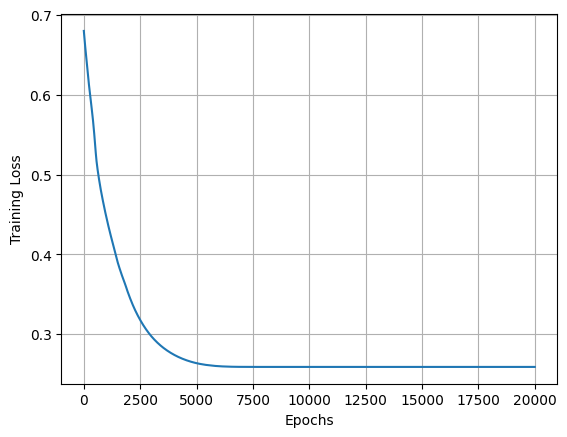

In [5]:
df_train= pd.read_csv("/kaggle/input/dlmi-mms-data/dlmi-lymphocytosis-classification/trainset/trainset_true.csv")
df_test = pd.read_csv("/kaggle/input/dlmi-mms-data/dlmi-lymphocytosis-classification/testset/testset_data.csv")

df_train['Year_of_Birth'] = df_train['DOB'].apply(parse_date_with_multiple_formats)
X_train = df_train[['LYMPH_COUNT','Year_of_Birth']].values
Y_train = df_train[['LABEL']].values

df_test['Year_of_Birth'] = df_test['DOB'].apply(parse_date_with_multiple_formats)
X_test = df_test[['LYMPH_COUNT','Year_of_Birth']].values

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)

# Define the MLP model
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(2, 2)
        self.fc2 = nn.Linear(2, 1)
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return x

# Initialize the model, loss, and optimizer
model = MLP()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 20000
total_loss = []
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_train_tensor)
    loss = criterion(outputs, Y_train_tensor)
    
    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    total_loss.append(loss.item())
    
    if (epoch+1) % 1000 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')

# Prediction on test set
with torch.no_grad():  
    test_outputs = model(X_test_tensor)
    predicted_labels = test_outputs.round()  # Round to 0 or 1
    
df_predicted = pd.DataFrame({
    'Id': df_test['ID'], 
    'Predicted': predicted_labels.view(-1).numpy().astype(int)
})

print(df_predicted)

# Save the DataFrame to a CSV file
csv_file_path = '/kaggle/working/predicted_labels_MLP_clinical_data.csv'
df_predicted.to_csv(csv_file_path, index=False)
print(f"Predictions saved to {csv_file_path}")

# Plot the losses during the training
plt.plot(total_loss)
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.show()

----
### <b> Basic MLP - 2 layers - Validation Stratified </b>

Epoch [1000/10000], Loss: 0.4754500091075897, Validation Loss: 0.42494457960128784
Epoch [2000/10000], Loss: 0.42037251591682434, Validation Loss: 0.34360358119010925
Epoch [3000/10000], Loss: 0.37846311926841736, Validation Loss: 0.32521188259124756
Epoch [4000/10000], Loss: 0.34265875816345215, Validation Loss: 0.30373698472976685
Epoch [5000/10000], Loss: 0.3160984218120575, Validation Loss: 0.28614673018455505
Epoch [6000/10000], Loss: 0.29743102192878723, Validation Loss: 0.27195051312446594
Epoch [7000/10000], Loss: 0.2843656539916992, Validation Loss: 0.2604537010192871
Epoch [8000/10000], Loss: 0.275458425283432, Validation Loss: 0.2510276138782501
Epoch [9000/10000], Loss: 0.26988643407821655, Validation Loss: 0.24354781210422516
Epoch [10000/10000], Loss: 0.26660609245300293, Validation Loss: 0.23753882944583893
Predictions saved to /kaggle/working/predicted_labels_MLP_clinical_data_stratified.csv


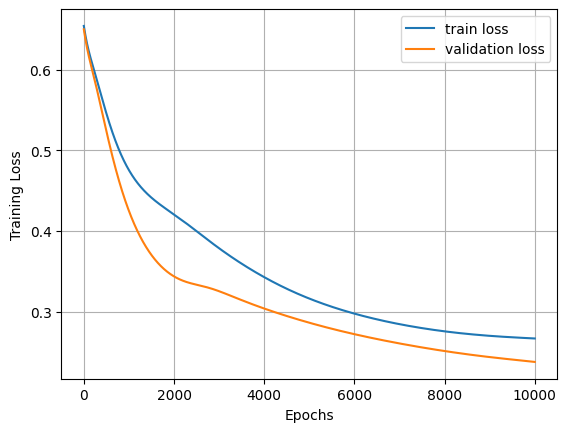

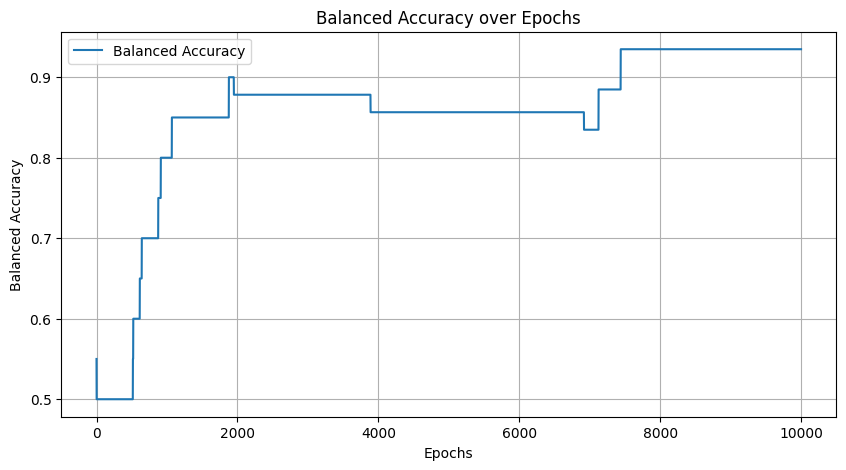

In [6]:
df_train = pd.read_csv("/kaggle/input/dlmi-mms-data/dlmi-lymphocytosis-classification/trainset/trainset_true.csv")
df_test = pd.read_csv("/kaggle/input/dlmi-mms-data/dlmi-lymphocytosis-classification/testset/testset_data.csv")

# Process the datasets
df_train['Year_of_Birth'] = df_train['DOB'].apply(parse_date_with_multiple_formats)
X_train = df_train[['LYMPH_COUNT', 'Year_of_Birth']].values
Y_train = df_train[['LABEL']].values.ravel()  # Flatten Y_train for stratified splitting

df_test['Year_of_Birth'] = df_test['DOB'].apply(parse_date_with_multiple_formats)
X_test = df_test[['LYMPH_COUNT', 'Year_of_Birth']].values

# Split the training data into training and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, stratify=Y_train, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32).view(-1, 1)
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
Y_val_tensor = torch.tensor(Y_val, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(2, 2)
        self.fc2 = nn.Linear(2, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.sigmoid(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return x

# Initialize the model, loss, and optimizer
model = MLP()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop with validation
num_epochs = 10000
total_loss_train = []
total_loss_validation = []
balanced_acc_scores = []
for epoch in range(num_epochs):
    outputs = model(X_train_tensor)
    loss = criterion(outputs, Y_train_tensor)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    total_loss_train.append(loss.item())

    # Validation loss
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        val_loss = criterion(val_outputs, Y_val_tensor)
        total_loss_validation.append(val_loss.item())
        
        val_preds = val_outputs.round().numpy()
        val_acc = balanced_accuracy_score(Y_val_tensor.numpy(), val_preds)
        balanced_acc_scores.append(val_acc)
    
    if (epoch+1) % 1000 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}, Validation Loss: {val_loss.item()}')

# Prediction on test set
with torch.no_grad():  
    test_outputs = model(X_test_tensor)
    predicted_labels = test_outputs.round()  # Round to 0 or 1
    
df_predicted = pd.DataFrame({
    'Id': df_test['ID'], 
    'Predicted': predicted_labels.view(-1).numpy().astype(int)
})

csv_file_path = '/kaggle/working/predicted_labels_MLP_clinical_data_stratified.csv'
df_predicted.to_csv(csv_file_path, index=False)
print(f"Predictions saved to {csv_file_path}")

# Plot train losses
plt.plot(total_loss_train,label='train loss')
plt.plot(total_loss_validation, label='validation loss')
plt.grid()
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(balanced_acc_scores, label='Balanced Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Balanced Accuracy')
plt.title('Balanced Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.show()


----
### <b> Basic MLP Model 2 layer - Using stratified K Fold </b>

Starting Fold 1


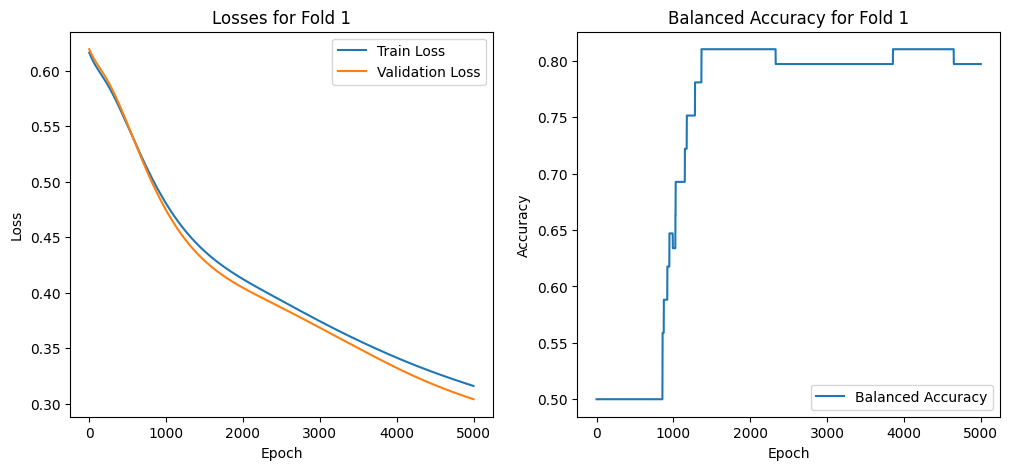

Starting Fold 2


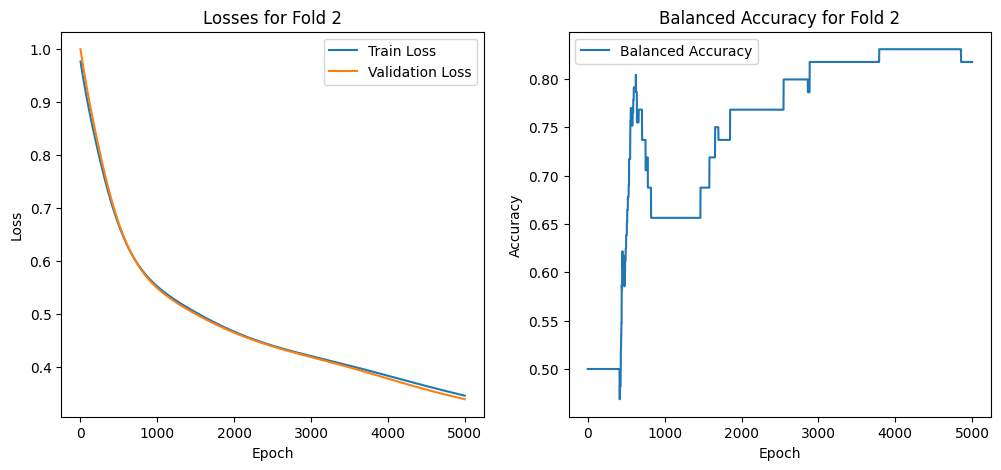

Starting Fold 3


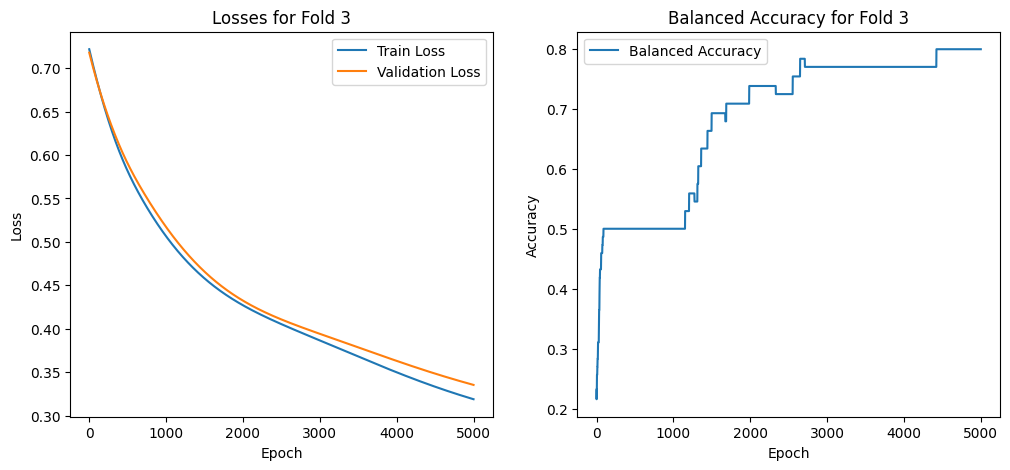

Predictions saved to /kaggle/working/predicted_labels_best_model.csv


In [7]:
# Load and preprocess data
df_train = pd.read_csv("/kaggle/input/dlmi-mms-data/dlmi-lymphocytosis-classification/trainset/trainset_true.csv")
df_test = pd.read_csv("/kaggle/input/dlmi-mms-data/dlmi-lymphocytosis-classification/testset/testset_data.csv")
df_train['Year_of_Birth'] = df_train['DOB'].apply(parse_date_with_multiple_formats)
X_train = df_train[['LYMPH_COUNT', 'Year_of_Birth']].values
Y_train = df_train['LABEL'].values.ravel()
df_test['Year_of_Birth'] = df_test['DOB'].apply(parse_date_with_multiple_formats)
X_test = df_test[['LYMPH_COUNT', 'Year_of_Birth']].values

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(2, 2)
        self.fc2 = nn.Linear(2, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.sigmoid(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return x

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
fold_no = 1
fold_losses = []
fold_accuracies = []

for train_index, val_index in skf.split(X_train_scaled, Y_train):
    print(f'Starting Fold {fold_no}')
    X_train_fold, X_val_fold = X_train_scaled[train_index], X_train_scaled[val_index]
    Y_train_fold, Y_val_fold = Y_train[train_index], Y_train[val_index]

    X_train_tensor = torch.tensor(X_train_fold, dtype=torch.float32)
    Y_train_tensor = torch.tensor(Y_train_fold, dtype=torch.float32).view(-1, 1)
    X_val_tensor = torch.tensor(X_val_fold, dtype=torch.float32)
    Y_val_tensor = torch.tensor(Y_val_fold, dtype=torch.float32).view(-1, 1)

    model = MLP()
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    epoch_losses_train = []
    epoch_losses_val = []
    epoch_accuracies_val = []

    # Training loop
    for epoch in range(5000):
        outputs = model(X_train_tensor)
        loss = criterion(outputs, Y_train_tensor)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_losses_train.append(loss.item())

        with torch.no_grad():
            val_outputs = model(X_val_tensor)
            val_loss = criterion(val_outputs, Y_val_tensor)
            val_preds = val_outputs.round().numpy()
            val_acc = balanced_accuracy_score(Y_val_tensor.numpy(), val_preds)

        epoch_losses_val.append(val_loss.item())
        epoch_accuracies_val.append(val_acc)

    model_path = f'/kaggle/working/model_fold_{fold_no}.pth'
    torch.save(model.state_dict(), model_path)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epoch_losses_train, label='Train Loss')
    plt.plot(epoch_losses_val, label='Validation Loss')
    plt.title(f'Losses for Fold {fold_no}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epoch_accuracies_val, label='Balanced Accuracy')
    plt.title(f'Balanced Accuracy for Fold {fold_no}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

    # Accumulate fold results
    fold_losses.append(epoch_losses_val[-1])
    fold_accuracies.append(epoch_accuracies_val[-1])
    
    fold_no += 1

## TEST ##
best_fold = np.argmax(fold_accuracies) + 1  # +1 because fold_no starts from 1
best_model_path = f'/kaggle/working/model_fold_{best_fold}.pth'

best_model = MLP()
best_model.load_state_dict(torch.load(best_model_path))
best_model.eval()  

with torch.no_grad():  
    test_outputs = best_model(X_test_tensor)
    predicted_labels = test_outputs.round().numpy().astype(int)
    
df_predicted = pd.DataFrame({
    'Id': df_test['ID'], 
    'Predicted': predicted_labels.flatten()
})

csv_file_path = '/kaggle/working/predicted_labels_best_model.csv'
df_predicted.to_csv(csv_file_path, index=False)
print(f"Predictions saved to {csv_file_path}")


----
### <b> Bigger MLP models </b>

Starting Fold 1


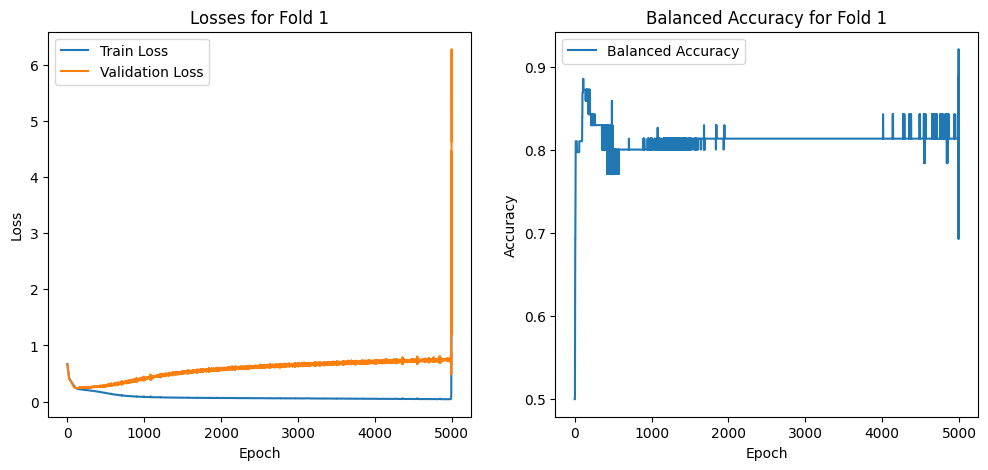

Starting Fold 2


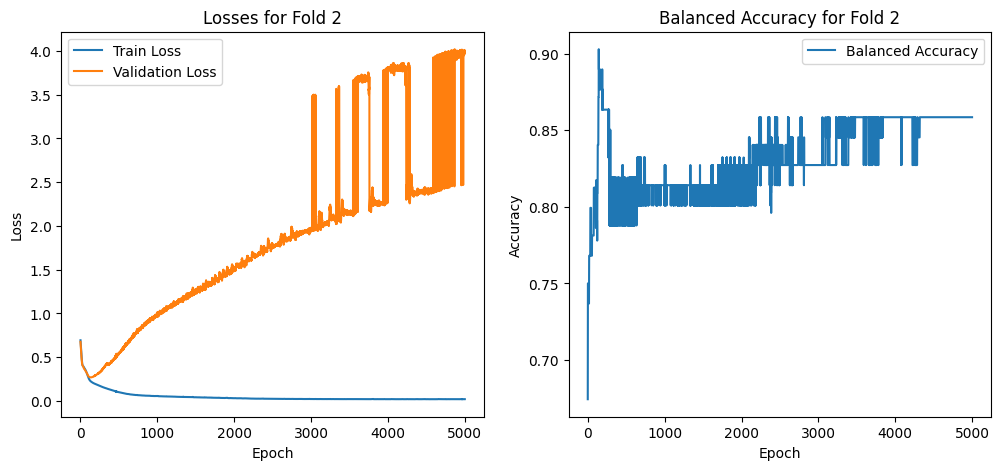

Starting Fold 3


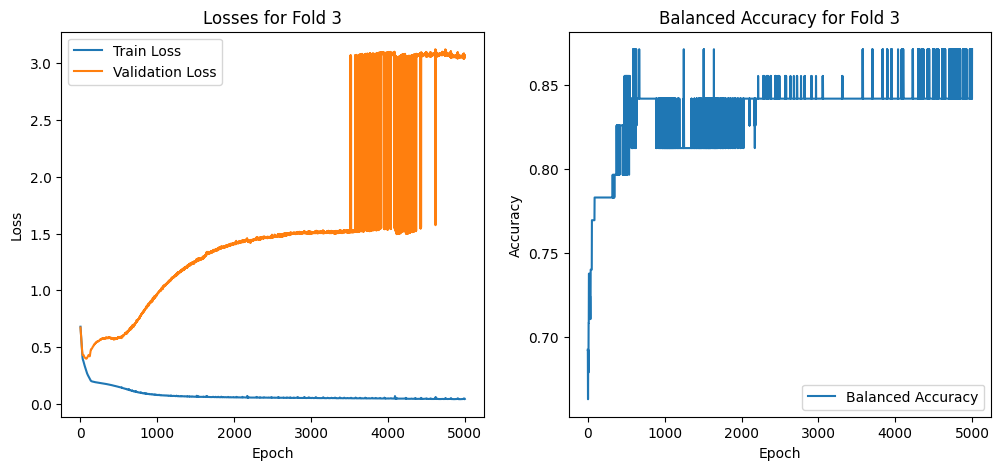

In [8]:
# Load and preprocess data
df_train = pd.read_csv("/kaggle/input/dlmi-mms-data/dlmi-lymphocytosis-classification/trainset/trainset_true.csv")
df_test = pd.read_csv("/kaggle/input/dlmi-mms-data/dlmi-lymphocytosis-classification/testset/testset_data.csv")
df_train['Year_of_Birth'] = df_train['DOB'].apply(parse_date_with_multiple_formats)
X_train = df_train[['LYMPH_COUNT', 'Year_of_Birth']].values
Y_train = df_train['LABEL'].values.ravel()
df_test['Year_of_Birth'] = df_test['DOB'].apply(parse_date_with_multiple_formats)
X_test = df_test[['LYMPH_COUNT', 'Year_of_Birth']].values

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

class ComplexMLP(nn.Module):
    def __init__(self):
        super(ComplexMLP, self).__init__()
        self.fc1 = nn.Linear(2, 64)  
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 1)  

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))
        return x

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
fold_no = 1
fold_losses = []
fold_accuracies = []

for train_index, val_index in skf.split(X_train_scaled, Y_train):
    print(f'Starting Fold {fold_no}')
    X_train_fold, X_val_fold = X_train_scaled[train_index], X_train_scaled[val_index]
    Y_train_fold, Y_val_fold = Y_train[train_index], Y_train[val_index]

    X_train_tensor = torch.tensor(X_train_fold, dtype=torch.float32)
    Y_train_tensor = torch.tensor(Y_train_fold, dtype=torch.float32).view(-1, 1)
    X_val_tensor = torch.tensor(X_val_fold, dtype=torch.float32)
    Y_val_tensor = torch.tensor(Y_val_fold, dtype=torch.float32).view(-1, 1)

    model = ComplexMLP()
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    epoch_losses_train = []
    epoch_losses_val = []
    epoch_accuracies_val = []

    # Training loop
    for epoch in range(5000):
        outputs = model(X_train_tensor)
        loss = criterion(outputs, Y_train_tensor)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_losses_train.append(loss.item())

        with torch.no_grad():
            val_outputs = model(X_val_tensor)
            val_loss = criterion(val_outputs, Y_val_tensor)
            val_preds = val_outputs.round().numpy()
            val_acc = balanced_accuracy_score(Y_val_tensor.numpy(), val_preds)

        epoch_losses_val.append(val_loss.item())
        epoch_accuracies_val.append(val_acc)

    model_path = f'/kaggle/working/model_fold_ComplexMLP_{fold_no}.pth'
    torch.save(model.state_dict(), model_path)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epoch_losses_train, label='Train Loss')
    plt.plot(epoch_losses_val, label='Validation Loss')
    plt.title(f'Losses for Fold {fold_no}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epoch_accuracies_val, label='Balanced Accuracy')
    plt.title(f'Balanced Accuracy for Fold {fold_no}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

    # Accumulate fold results
    fold_losses.append(epoch_losses_val[-1])
    fold_accuracies.append(epoch_accuracies_val[-1])
    
    fold_no += 1



----
### <b> MLP models with balanced loss </b>

In [10]:
def calculate_age_from_dob(dob, reference_date=pd.Timestamp('today')):
    formats = ['%m/%d/%Y', '%d-%m-%Y']  # List of formats to try
    for fmt in formats:
        try:
            birth_date = pd.to_datetime(dob, format=fmt)
            age = reference_date.year - birth_date.year - ((reference_date.month, reference_date.day) < (birth_date.month, birth_date.day))
            return age
        except ValueError:
            continue
    return None

df_train = pd.read_csv("/kaggle/input/dlmi-mms-data/dlmi-lymphocytosis-classification/trainset/trainset_true.csv")
df_test = pd.read_csv("/kaggle/input/dlmi-mms-data/dlmi-lymphocytosis-classification/testset/testset_data.csv")


df_train['Age'] = df_train['DOB'].apply(calculate_age_from_dob)
df_test['Age'] = df_test['DOB'].apply(calculate_age_from_dob)

X_train = df_train[['LYMPH_COUNT', 'Age']].values
Y_train = df_train['LABEL'].values
X_test = df_test[['LYMPH_COUNT', 'Age']].values

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(2, 2)
        self.fc2 = nn.Linear(2, 1)

    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))  
        x = self.fc2(x)  # No sigmoid here, BCEWithLogitsLoss applies it
        return x

# Initialize model, loss function, and optimizer
model = MLP()
class_counts = np.array([2592, 10861])
weight_for_0 = (1 / class_counts[0]) * (class_counts.sum() / 2.0)
weight_for_1 = (1 / class_counts[1]) * (class_counts.sum() / 2.0)
weights_tensor = torch.tensor([weight_for_0, weight_for_1], dtype=torch.float32)
criterion = nn.BCEWithLogitsLoss(pos_weight=weights_tensor[1])
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10000  
for epoch in range(num_epochs):
    # Forward pass and compute loss
    outputs = model(X_train_tensor)
    loss = criterion(outputs, Y_train_tensor)
    
    # Backward pass and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 1000 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')

with torch.no_grad():
    test_outputs = model(X_test_tensor)
    predicted_labels = torch.round(torch.sigmoid(test_outputs))  # Sigmoid and round to get binary class

# Create a DataFrame with 'ID' and 'Predicted_LABEL'
df_predicted = pd.DataFrame({
    'Id': df_test['ID'], 
    'Predicted': predicted_labels.view(-1).numpy()
})
df_predicted['Predicted'] = df_predicted['Predicted'].astype(int)

# Save predictions to CSV
csv_file_path = '/kaggle/working/PREDICT_MLP_SMALL_BALANCED.csv'
df_predicted.to_csv(csv_file_path, index=False)
print(f"Predictions saved to {csv_file_path}")


Epoch [1000/10000], Loss: 0.4064958393573761
Epoch [2000/10000], Loss: 0.34355929493904114
Epoch [3000/10000], Loss: 0.3184696435928345
Epoch [4000/10000], Loss: 0.2885308563709259
Epoch [5000/10000], Loss: 0.26198527216911316
Epoch [6000/10000], Loss: 0.24187085032463074
Epoch [7000/10000], Loss: 0.22736121714115143
Epoch [8000/10000], Loss: 0.21689331531524658
Epoch [9000/10000], Loss: 0.20949456095695496
Epoch [10000/10000], Loss: 0.20464986562728882
Predictions saved to /kaggle/working/PREDICT_MLP_SMALL_BALANCED.csv


----
## <b> 2 - XGBOOST </b>

### <b> GridSearchCV </b>

In [11]:
# Load and preprocess data
df_train = pd.read_csv("/kaggle/input/dlmi-mms-data/dlmi-lymphocytosis-classification/trainset/trainset_true.csv")
df_test = pd.read_csv("/kaggle/input/dlmi-mms-data/dlmi-lymphocytosis-classification/testset/testset_data.csv")

df_train['Year_of_Birth'] = df_train['DOB'].apply(parse_date_with_multiple_formats)
X_train = df_train[['LYMPH_COUNT', 'Year_of_Birth']].values
Y_train = df_train['LABEL'].values.ravel()

df_test['Year_of_Birth'] = df_test['DOB'].apply(parse_date_with_multiple_formats)
X_test = df_test[['LYMPH_COUNT', 'Year_of_Birth']].values

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define XGBoost model parameters to search
params = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 200],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1],
}

xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Grid Search with StratifiedKFold
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
grid_search = GridSearchCV(xgb_model, params, scoring='balanced_accuracy', cv=skf, verbose=1)

# Fit the model
grid_search.fit(X_train_scaled, Y_train)

# Best model
best_model = grid_search.best_estimator_
print("Best model parameters:", grid_search.best_params_)
print("Best model score (balanced accuracy):", grid_search.best_score_)

# Predictions on the test set
test_predictions = best_model.predict(X_test_scaled)

# Create DataFrame with predictions
df_predicted = pd.DataFrame({
    'Id': df_test['ID'],
    'Predicted': test_predictions
})

# Save to CSV
csv_file_path = '/kaggle/working/predicted_labels_xgboost_gridsearch.csv'
df_predicted.to_csv(csv_file_path, index=False)
print(f"Predictions saved to {csv_file_path}")


Fitting 3 folds for each of 48 candidates, totalling 144 fits
Best model parameters: {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1}
Best model score (balanced accuracy): 0.8438563369871419
Predictions saved to /kaggle/working/predicted_labels_xgboost_gridsearch.csv
